In [3]:
from google.cloud import storage
import scipy
from scipy import signal
from scipy.signal import find_peaks
from scipy import stats
from scipy.stats import shapiro
import numpy as np
import pandas as pd
import os
import sys
import scipy.interpolate as interp
sys.path.append(os.path.join(sys.path[0], '..', 'src'))
import excel_reader_gcp as excel_reader
print("The module is located at:", excel_reader.__file__)
import datetime
import logging   
import csv
import matplotlib.pyplot as plt
from hmmlearn import hmm
from sklearn.model_selection import train_test_split
import random
import copy

The module is located at: c:\GP-WearablesAnalysis\examples\excel_reader_gcp.py


In [13]:
""" Data grouping/splitting pipeline:"""

""" Split the data into desired number of groups, and extract the first "target mean" from the first group. Subsequent target means are calculated as X% (percent grading) away from previous groups
    ex. if 3% is selected, means of groups will increment by 3% - the direction of incrementing (up/down) depends on whether reverse is selected 
    Iterate through indices in the gait parameter data (in this case, STSR) and append to a grouping if they are within a threshold from the target mean. 
    Sort both the gait parameter and corresponding gait cycles based on the chosen indices. 
"""

def finding_groupings(num_groups, gait_parameter, gait_cycles, percent_grading, reverse=True):
    
    if reverse:
        percent_grading = -percent_grading
        values_sorted = sorted(gait_parameter, reverse=True)
        sorted_indices = np.argsort(gait_parameter)[::-1]  # Sort indices in descending order of stance time symmetry
    else:
        sorted_indices = np.argsort(gait_parameter)
        values_sorted = sorted(gait_parameter, reverse=False)

    n = len(gait_parameter)
    group_sizes = [n // num_groups + (1 if i < n % num_groups else 0) for i in range(num_groups)]
    target_means = [np.mean(values_sorted[:group_sizes[0]])]

    # Initializes the groups and the remaining values to be picked from
    groups = [[] for _ in range(num_groups)]
    grouped_gait_cycles = [[] for _ in range(num_groups)]
    remaining_indices = sorted_indices[:]

    for i in range(1, num_groups):
        target_means.append(target_means[0] + percent_grading * i)

    for i in range(num_groups):
        target_mean = target_means[i]
        filtered_indices = [idx for idx in remaining_indices if abs(gait_parameter[idx] - target_mean) < percent_grading / 2]
        selected_indices = filtered_indices[:]
        groups[i].extend(gait_parameter[idx] for idx in selected_indices)
        grouped_gait_cycles[i].extend(gait_cycles[idx] for idx in selected_indices)
        remaining_indices = [idx for idx in remaining_indices if idx not in selected_indices]

    return groups, grouped_gait_cycles, percent_grading            

""" Random Sampling Gait Cycles:"""

""" random_sampling: Randomly sample 50 gait cycles from group 1. This serves as the "first_mean" that will be compared to in adaptive subsampling.
    adaptive_subsample: Randomly sample 50 gait cycles from a given group. If it is within X% * i +/- tolerance (i is the index of the group (ex. group 2 = 1)), then that group is accepted.
    Otherwise, the maximum or minimum is removed and another value still available is added (depending on if the current percent difference is too high or too low)
    Handles if the means are decreasing or increasing (if percent_diff is negative or positive)
    Returns the indices of the groups, and these are used to update the new groups in random_sampling.
"""

def random_sampling(groups, grouped_gait_cycles, sample_size=50):
    def adaptive_subsample(group, first_mean, i, percent_grading=0.03, tolerance=0.005, sample_size=50, max_iterations=10000):
        available_indices = list(range(len(group)))  # Make a list that spans all the indices
        sample_indices = np.random.choice(available_indices, size=sample_size, replace=False)
        
        for idx in sample_indices:
            available_indices.remove(idx)  # Remove initial sample values from available values
        for _ in range(max_iterations):
            current_mean = np.mean([group[idx] for idx in sample_indices])
            percent_diff = current_mean - first_mean 
            target_diff = percent_grading * i

            if len(available_indices) == 0:
                raise ValueError("No candidates available to adjust the mean")
            if (target_diff - tolerance) <= abs(percent_diff) <= (target_diff + tolerance):
                return sample_indices
            elif abs(percent_diff) < (target_diff - tolerance):
                if percent_diff < 0:
                    # Choose a new sample from the lower half
                    lower_idx = [idx for idx in available_indices if group[idx] <= np.percentile(group, 50)]
                    
                    if lower_idx:
                        new_idx = np.random.choice(lower_idx)
                        sample_indices = np.append(sample_indices, new_idx)
                    else:
                        new_idx = np.random.choice(available_indices)
                        sample_indices = np.append(sample_indices, new_idx)
                    
                    available_indices.remove(new_idx)
                    sample_indices = np.delete(sample_indices, np.argmax([group[idx] for idx in sample_indices]))
                else:
                    # Choose a new sample from the upper half
                    higher_idx = [idx for idx in available_indices if group[idx] >= np.percentile(group, 50)]
                    if higher_idx:
                        new_idx = np.random.choice(higher_idx)
                        sample_indices = np.append(sample_indices, new_idx)
                    else:
                        new_idx = np.random.choice(available_indices)
                        sample_indices = np.append(sample_indices, new_idx)
                    
                    available_indices.remove(new_idx)
                    sample_indices = np.delete(sample_indices, np.argmin([group[idx] for idx in sample_indices]))
            else:
                if percent_diff > 0:
                    lower_idx = [idx for idx in available_indices if group[idx] <= np.percentile(group, 50)]
                    if lower_idx:
                        new_idx = np.random.choice(lower_idx)
                        sample_indices = np.append(sample_indices, new_idx)
                    else:
                        new_idx = np.random.choice(available_indices)
                        sample_indices = np.append(sample_indices, new_idx)
                    
                    available_indices.remove(new_idx)
                    sample_indices = np.delete(sample_indices, np.argmax([group[idx] for idx in sample_indices]))
                else:
                    # Choose a new sample from the upper half
                    higher_idx = [idx for idx in available_indices if group[idx] >= np.percentile(group, 50)]
                    if higher_idx:
                        new_idx = np.random.choice(lower_idx)
                        sample_indices = np.append(sample_indices, new_idx)
                    else:
                        new_idx = np.random.choice(available_indices)
                        sample_indices = np.append(sample_indices, new_idx)
                    
                    available_indices.remove(new_idx)
                    sample_indices = np.delete(sample_indices, np.argmin([group[idx] for idx in sample_indices]))

        raise ValueError("Could not find suitable subsample within the maximum number of iterations")

    indices_first_group = list(range(len(groups[0])))  
    sample_indices_first_group = np.random.choice(indices_first_group, size=sample_size*2, replace=False)
    group1_mean = np.mean([groups[0][idx] for idx in sample_indices_first_group]) # first mean used as the target for all subsequent groups
    
    random.shuffle(sample_indices_first_group)
    baseline_1_indices = sample_indices_first_group[:50]
    baseline_2_indices = sample_indices_first_group[50:]
    
    
    subsampled_values_baseline1 = [groups[0][j] for j in baseline_1_indices]
    subsampled_gait_cycles_baseline1 = [grouped_gait_cycles[0][j] for j in baseline_1_indices]
    
    subsampled_values_baseline2 = [groups[0][j] for j in baseline_2_indices]
    subsampled_gait_cycles_baseline2 = [grouped_gait_cycles[0][j] for j in baseline_2_indices]
    
    groups_subsampled_list = []
    gaitcycles_subsampled_list = []
    
    groups_subsampled_list.append(subsampled_values_baseline1)
    groups_subsampled_list.append(subsampled_values_baseline2)
    
    gaitcycles_subsampled_list.append(subsampled_gait_cycles_baseline1)
    gaitcycles_subsampled_list.append(subsampled_gait_cycles_baseline2)
    
    #Only consider 3 groups here
    for i in range(1, 3):
        sample_indices = adaptive_subsample(np.array(groups[i]), group1_mean, i)
        subsampled_values = [groups[i][j] for j in sample_indices]
        subsampled_gait_cycles = [grouped_gait_cycles[i][j] for j in sample_indices]
        groups_subsampled_list.append(subsampled_values)
        gaitcycles_subsampled_list.append(subsampled_gait_cycles)
    
    return groups_subsampled_list, gaitcycles_subsampled_list

""" Group splitting and sampling are called. Checks to see which direction the grouping should be done in, and only appends the groups that have at least 70 points"""

def check_group_configurations(gait_split_parameter, raw_sensor_data):
    percent_grading = 0.03
    groups, grouped_gait_cycles, grading = finding_groupings(4, gait_split_parameter, raw_sensor_data, percent_grading, reverse=False)
    
    filtered_groups = []
    filtered_gait_groups = []
    
    for i in range(len(groups)):
        if len(groups[i]) > 70:
            filtered_groups.append(groups[i])
            filtered_gait_groups.append(grouped_gait_cycles[i])
    
    if len(filtered_groups) < 3:
        groups, grouped_gait_cycles, grading = finding_groupings(4, gait_split_parameter, raw_sensor_data, percent_grading, reverse=True)  # Try the other direction if requirements are not fulfilled
        filtered_groups = []
        filtered_gait_groups = []
        
        for i in range(len(groups)):
            if len(groups[i]) > 70:
                filtered_groups.append(groups[i])
                filtered_gait_groups.append(grouped_gait_cycles[i])

        if len(filtered_groups) < 3:
            raise ValueError("Insufficient group sizes available for this participant")
    
    groups, gaitcycles = random_sampling(filtered_groups, filtered_gait_groups)
    
    return groups, gaitcycles

In [4]:
XsensGaitParser =  excel_reader.XsensGaitDataParser()
storage_client = storage.Client()
bucket_name = 'gaitbfb_propellab/'
base_directory = bucket_name + 'Wearable Biofeedback System (REB-0448)/Data/Raw Data'
bucket_name = 'gaitbfb_propellab'
blobs = storage_client.list_blobs(bucket_name, prefix = base_directory)
prefix_from_bucket = 'Wearable Biofeedback System (REB-0448)/Data/Raw Data/' 
#participant_list = ['LLPU_P01','LLPU_P02','LLPU_P03','LLPU_P04','LLPU_P06','LLPU_P08','LLPU_P09','LLPU_P10','LLPU_P12','LLPU_P15']


participant_list = ['LLPU_P01','LLPU_P02','LLPU_P03','LLPU_P04','LLPU_P05','LLPU_P06','LLPU_P09','LLPU_P10','LLPU_P12','LLPU_P15']
#participant_list = ['LLPU_P01','LLPU_P02','LLPU_P03','LLPU_P04',,'LLPU_P05''LLPU_P05','LLPU_P06','LLPU_P08','LLPU_P09','LLPU_P12', 'LLPU_P15']

arrangements = ['pelvis','upper','lower']

participant_info = pd.read_excel('Q:\\main_propellab\\Users\\Ng, Gabe\\Summer Student 2024\\LLPU_DataSummaries\\LLPU_Height_ProstheticSide.xlsx')

def get_participant_info(participant_id):
    participant = participant_info[participant_info['Participant_ID'] == participant_id]
    if not participant.empty:
        height = participant.iloc[0]['Height']
        side = int(participant.iloc[0]['Side'])
        return height, side
    else:
        return None, None

#Dictionary to map the sensor locations to their IDs.
sensor_mappings = {
    'pelvis': 1,
    'UpperR': 2,
    'LowerR': 3,
    'UpperL': 5,
    'LowerL': 6
}

def reshape_vector(vectors_orig, new_size, num_axes=3):
    x_new = np.linspace(0, 100, new_size)
    trial_reshaped = []
    for stride in vectors_orig:
        x_orig = np.linspace(0, 100, len(stride))
        func_cubic = [interp.interp1d(x_orig, stride[:, i], kind='cubic') for i in range(num_axes)]
        vec_cubic = np.array([func_cubic[i](x_new) for i in range(num_axes)]).transpose()
        trial_reshaped.append(vec_cubic)
    return np.array(trial_reshaped)

#uses dictionaries to extract the relevant raw sensor data, reshapes the data, then concatenates gyro and accelerometer signals together 
def organize_signals(sensor_mappings, gyro_signal, accel_signal):
    combined_signals = {}
    for location, sensor in sensor_mappings.items():
        reshaped_gyro = reshape_vector(gyro_signal[sensor], 40, 3)
        reshaped_accel = reshape_vector(accel_signal[sensor], 40, 3)
        combined_signals[location] = np.concatenate((reshaped_gyro, reshaped_accel), axis=2) #Concatenates to gyro x,y,z and accel x,y,z
    return combined_signals

for participant in participant_list:
    print(f"Processing participant {participant}")
    
    participant_id = participant
    height,side = get_participant_info(participant_id)
    print(type(side))
    height_m = height/100 
    
    if side == 1:
        prosth_side = 0 #Right side
        non_prosth_side = 1
        side_label = "Right"
        print("Prosthetic on the right side")
    else:
        prosth_side = 1 #Left side
        non_prosth_side = 0
        side_label = "Left"
        print("Prosthetic side on the left side")
    
    if height is None or side is None:
        print(f"Participant info not found for ID: {participant_id}")
        continue
    
    directory = prefix_from_bucket + participant + '/Excel_Data_Trimmed'
    blobs = storage_client.list_blobs(bucket_or_name=bucket_name, prefix=directory.replace("\\", "/"))
    part_strides = {}
    part_gait_params = {}
    part_kinematic_params = {}
    part_raw_sensor = []
    trial_type = 'LLPU'
    height_normalized = True
    part_strides_baseline = {}
    part_gait_params_baseline = {}
    part_kinematic_params_baseline = {}
    part_sensor_data_baseline = []
    knee_roms_list = []
    hip_roms_list = []
    step_lengths_list = []
    ankle_roms_list = []
    
    logging.info(f"Processing participant {participant}")
    if blobs:
        for blob in blobs:
            if blob.name.endswith('.csv'):
                try:
                    XsensGaitParser.process_mvn_trial_data(f"gs://{bucket_name}/{blob.name}")
                    partitioned_mvn_data = XsensGaitParser.get_partitioned_mvn_data()
                    gait_params = XsensGaitParser.get_gait_param_info()
                    combined_signals = organize_signals(sensor_mappings, partitioned_mvn_data['gyro_data'], partitioned_mvn_data['acc_data'])
                    pelvis_data = combined_signals['pelvis']
                    upper_data = np.concatenate((combined_signals['UpperR'], combined_signals['UpperL']), axis=2)  # Concatenate by last axis
                    lower_data = np.concatenate((combined_signals['LowerR'], combined_signals['LowerL']), axis=2)  # Concatenate by last axis
                    full_sensors = np.concatenate((pelvis_data,upper_data,lower_data),axis=2)
                    part_raw_sensor.append(full_sensors)

                    if trial_type in part_strides:
                        for body_part in part_strides[trial_type]:
                            for i, side in enumerate(part_strides[trial_type][body_part]):
                                # for each part (pelvis, l_hip, r_knee, etc.), append strides to appropriate list
                                part_strides[trial_type][body_part][i] = part_strides[trial_type][body_part][i] + partitioned_mvn_data[body_part][i]
                               
                        part_gait_params[trial_type].append(gait_params['spatio_temp'])
                        
                        for joint in part_kinematic_params[trial_type]:
                            for i, side in enumerate(part_kinematic_params[trial_type][joint]):
                                part_kinematic_params[trial_type][joint][i] = np.append(part_kinematic_params[trial_type][joint][i], gait_params['kinematics'][joint][i], axis=0) 

                    else:
                        part_strides[trial_type] = partitioned_mvn_data
                        part_gait_params[trial_type] = [gait_params['spatio_temp']]
                        part_kinematic_params[trial_type] = gait_params['kinematics']
                    file_name = os.path.basename(blob.name)
                    
                    knee_roms = gait_params['spatio_temp'][13]
                    # Isolate the sagittal plane angle (flexion/extension)
                    knee_ROMs_full = [
                    [sublist[:][0][-1], sublist[:][1][-1]]
                    for sublist in knee_roms]
                    
                    knee_ROMs_sideofinterest = [
                    sublist[:][non_prosth_side]
                    for sublist in knee_ROMs_full] 
                    
                    knee_roms_list.append(knee_ROMs_sideofinterest)    
                    
                    
                    hip_roms = gait_params['spatio_temp'][14]
                    # Isolate the sagittal plane angle (flexion/extension)
                    hip_ROMs_full = [
                    [sublist[:][0][-1], sublist[:][1][-1]]
                    for sublist in hip_roms]
                    
                    hip_ROMs_sideofinterest = [
                    sublist[:][non_prosth_side]
                    for sublist in hip_ROMs_full] 
                    
                    hip_roms_list.append(hip_ROMs_sideofinterest) 
                    
                    ankle_roms = gait_params['spatio_temp'][15]
                    
                    ankle_ROMs_full = [
                    [sublist[:][0][-1], sublist[:][1][-1]]
                    for sublist in ankle_roms]
                    
                    ankle_ROMs_sideofinterest = [
                    sublist[:][non_prosth_side]
                    for sublist in ankle_ROMs_full] 
                    
                    ankle_roms_list.append(ankle_ROMs_sideofinterest) 
                
                    step_lengths = gait_params['spatio_temp'][10]
                    
                    if height_normalized == True:
                        step_length = step_lengths[prosth_side]/(height_m)
                        step_lengths_list.append(step_length)
                    else:
                        step_length = step_lengths[prosth_side]
                        step_lengths_list.append(step_length)
                        
                except IndexError as e: #Exception based on an Index Error encountered in excel_reader_gcp.py **
                    #print(f"File skipped: gs://{bucket_name}/{blob.name} due to error: {e}")
                    continue                              
    
    if trial_type in part_gait_params:
        stance_time_symmetry = [item for sublist in [i[12] for i in part_gait_params[trial_type]] for item in sublist]
        knee_ROM = [item for sublist in knee_roms_list for item in sublist]
        step_lengths = [item for sublist in step_lengths_list for item in sublist]
        hip_ROM = [item for sublist in hip_roms_list for item in sublist] 
        ankle_ROM = [item for sublist in ankle_roms_list for item in sublist] 
        # shap_stat, shap_p = shapiro(knee_ROM)
        
        # if shap_p > 0.05:
        #     print("Normally distributed",shap_p)
        # else:
        #     print('Data is not normally distributed',shap_p)
    # flattened_raw_sensor = []
    # for sublist in part_raw_sensor:
    #     for item in sublist:
    #         flattened_raw_sensor.append(item) #Flatten to individual gait cycles 
    
    # groups, gaitcycles = check_group_configurations(stance_time_symmetry, flattened_raw_sensor)
    # group_means = [np.mean(group) for group in groups]
    # group_lengths = [len(group) for group in groups]
    # print(group_means)
    # # Split each array and append to respective lists
    # gaitcycles_40x6 = [] #pelvis
    # gaitcycles_40x12_1 = [] #upper
    # gaitcycles_40x12_2 = [] #lower

    # # Iterate over each sublist in gaitcycles
    # for sublist in gaitcycles:
    #     sublist_40x6 = []
    #     sublist_40x12_1 = []
    #     sublist_40x12_2 = []
        
    #     # Split each array in the sublist
    #     for array in sublist:
    #         split_arrays = np.split(array, [6, 18], axis=1)  # Split the array into 40x6, 40x12, 40x12 parts
    #         sublist_40x6.append(split_arrays[0]) #Filter individual gait cycles and split them (first 6, next 12, next 12)
    #         sublist_40x12_1.append(split_arrays[1])
    #         sublist_40x12_2.append(split_arrays[2])
        
    #     # Append the split sublists to the main lists
    #     gaitcycles_40x6.append(sublist_40x6)
    #     gaitcycles_40x12_1.append(sublist_40x12_1)
    #     gaitcycles_40x12_2.append(sublist_40x12_2)
    # # print(group_means)
    
    # sensor = ['gyrox','gyroy','gyroz','accelx','accely','accelz']
    # colors = ['red','blue','green']
    # fig, axes = plt.subplots(1, 6, figsize=(20, 5))
    # for i, group in enumerate(gaitcycles_40x12_2):
    #     flattened_array = np.concatenate(group, axis=0)
    #     for j in range(6):
    #         excel_reader.visualize_strides(flattened_array, axes[j], j, i)
    #         axes[j].set_title(f'{sensor[j]}')
    # plt.show()

Processing participant LLPU_P01
<class 'int'>
Prosthetic on the right side


c:\Users\ekuep\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\ekuep\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Processing participant LLPU_P02
<class 'int'>
Prosthetic side on the left side
Processing participant LLPU_P03
<class 'int'>
Prosthetic side on the left side


c:\Users\ekuep\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\ekuep\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Processing participant LLPU_P04
<class 'int'>
Prosthetic side on the left side
Processing participant LLPU_P05
<class 'int'>
Prosthetic side on the left side


c:\Users\ekuep\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\ekuep\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\ekuep\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\ekuep\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Processing participant LLPU_P06
<class 'int'>
Prosthetic side on the left side
Processing participant LLPU_P09
<class 'int'>
Prosthetic on the right side


c:\Users\ekuep\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\ekuep\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Processing participant LLPU_P10
<class 'int'>
Prosthetic on the right side
Processing participant LLPU_P12
<class 'int'>
Prosthetic on the right side
Processing participant LLPU_P15
<class 'int'>
Prosthetic on the right side


In [7]:
hip_roms = gait_params['spatio_temp'][14]
print(np.shape(hip_roms))

ankle_roms = gait_params['spatio_temp'][15]
print(np.shape(ankle_roms))


                    

(14, 2, 3)
(14, 2, 3)


In [98]:
ankle_roms = gait_params['kinematics']['ankle_ROM']
print(ankle_roms)

[array([[ 5.34782017,  1.74772183, 18.91649667]]), array([[ 8.92322633, 19.89351567, 31.620123  ]])]


In [68]:
knee_roms = gait_params['spatio_temp'][14]
                    
# Apply the function to each sublist (left and right) within knee_ROMs
knee_ROMs_magnitude = [
    [sublist[:][0][-1], sublist[:][1][-1]]
    for sublist in knee_roms]

knee_ROMs = [
    sublist[:][prosth_side]
    for sublist in knee_ROMs_magnitude] 
                  
knee_roms_list.append(knee_ROMs)
print(knee_roms)
print(knee_ROMs)

print(ankle_ROM)

[[[10.051231 15.743379 34.936679]
  [ 5.78467   7.805017 33.028413]]

 [[ 9.942356 17.965179 35.300567]
  [ 6.704685  7.789404 32.58347 ]]

 [[10.523988 15.854882 34.337184]
  [ 7.610575  7.060281 34.00833 ]]

 [[10.753718 18.17127  36.112295]
  [ 8.027609  7.265825 33.530306]]

 [[10.62337  16.905658 34.056256]
  [ 7.850038  7.843706 32.355008]]

 [[10.250553 15.753785 33.437869]
  [ 7.546101  8.49474  32.650022]]]
[34.936679, 35.300567, 34.337184, 36.112295, 34.056256, 33.437869]
[]


695
695
[34.270682, 37.119356, 36.212975, 35.508489, 37.850816, 36.219953, 35.011790000000005, 35.68397, 34.927616, 33.295861, 36.448928, 36.47827, 35.767848, 36.843722, 37.205188, 37.74447, 37.538551, 37.910358, 36.538986, 36.035046, 33.099652999999996, 36.765516, 37.248388, 35.720813, 37.107072, 37.873989, 37.768487, 37.087691, 35.903438, 33.863634000000005, 39.914304, 38.910095999999996, 39.1762, 38.588561999999996, 37.921110999999996, 37.320927, 36.908812999999995, 33.084593999999996, 30.12947, 31.657759, 32.122121, 32.02449, 32.292047, 32.020955, 30.353269, 32.679204, 32.735220999999996, 31.921912, 32.8249, 32.243257, 33.302793, 35.254842000000004, 34.028657, 33.298590000000004, 34.624458000000004, 34.099345, 35.990145, 35.966806, 35.566979, 35.569362, 36.648969, 38.192995, 37.116455, 39.426237, 38.246826999999996, 36.662566999999996, 35.186145, 36.669666, 38.087188999999995, 37.317892, 39.778779, 38.65284, 37.448608, 36.85825, 38.265378, 38.857349, 39.717594, 39.682367, 38.667566

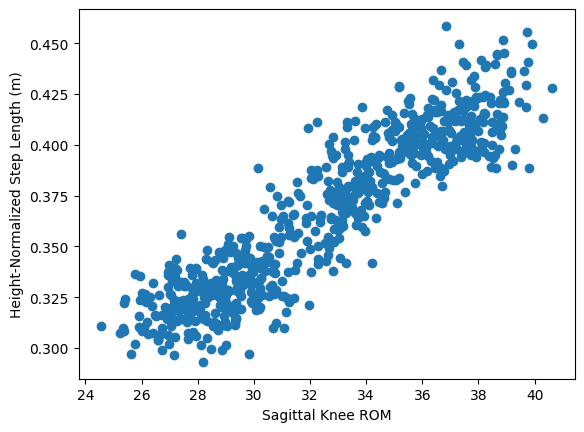

In [7]:

flattened_list = [item for sublist in knee_roms_list for item in sublist]

from scipy.stats import pearsonr 


X = stance_time_symmetry
Y = ankle_ROM
Z = step_lengths

print(len(Y))
print(len(Z))
print(Y)
print(Z)

corr_XY, p_value_XY = pearsonr(X, Y)
corr_XZ, p_value_XZ = pearsonr(X, Z)
corr_YZ, p_value_YZ = pearsonr(Y, Z)

plt.scatter(Y,Z)
plt.xlabel("Sagittal Knee ROM")
plt.ylabel("Height-Normalized Step Length (m)")

print(f"Pearson's correlation coefficient between STSR and ankle ROM: {corr_XY:.4f}, p-value: {p_value_XY:.4f}")
print(f"Pearson's correlation coefficient between STSR and step length: {corr_XZ:.4f}, p-value: {p_value_XZ:.4f}")
print(f"Pearson's correlation coefficient between Y and Z: {corr_YZ:.4f}, p-value: {p_value_YZ:.4f}")